# Feature Selection
Feature selection for the [UCI dataset](https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008). The dataset represents ten years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks.

Each row concerns hospital records of patients diagnosed with diabetes, who underwent laboratory, medications, and stayed up to 14 days. The goal is to determine the **early readmission of the patient within 30 days of discharge**.

The problem is important for the following reasons. Despite high-quality evidence showing improved clinical outcomes for diabetic patients who receive various preventive and therapeutic interventions, many patients do not receive them. This can be partially attributed to arbitrary diabetes management in hospital environments, which fail to attend to glycemic control. Failure to provide proper diabetes care not only increases the managing costs for the hospitals (as the patients are readmitted) but also impacts the morbidity and mortality of the patients, who may face complications associated with diabetes.

## **0. Initial Setup**
Taking care of package imports, defining work constants, and loading all necessary datasets.

### 0.1 Python imports

In [1]:
# Data Analysis
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Visualization configurations
pd.set_option('display.max_columns', 60)
plt.style.use('ggplot')
sns.set_style('white')

In [2]:
from collections import Counter

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from xgboost import XGBClassifier

### 0.2 Constants

In [3]:
DATA_PATH = '../data/original/'
DATA_PATH_PROCESSED = '../data/processed/'

RANDOM_STATE = 38

### 0.3 Loading datasets

In [4]:
diabetic_data = pd.read_csv(
    DATA_PATH_PROCESSED + 'diabetic_data_cleaned.csv',
    na_values='?',
    keep_default_na=False
)

## **1. Training & Test Split**
Splitting the dataset into training and test sets.

In [5]:
diabetic_data['readmitted'].value_counts(normalize=True) * 100

readmitted
0    90.964015
1     9.035985
Name: proportion, dtype: float64

It's pretty easy to see that there is a strong imbalance between the two classes we want to predict:

- **Late or non-readmission:** ~91%
- **Early-readmission:** ~9%

For this reason, we need to balance the training dataset to ensure that both classes will be predicted properly. Since we can already assume that the training set will drastically reduce in size, we apply a 70-30 split (70% training and 30% test).

In [6]:
# Remove discharge_home since it's highly correlated with discharge_transfer
diabetic_data.drop(columns=['discharge_home', 'medical_internal', 'medical_cardio', 'medical_surgery', 'HbA1c_none', 'HbA1c_norm', 'HbA1c_high_unchanged', 'HbA1c_high_changed'], inplace=True)

In [7]:
# Split in training and test sets
X = diabetic_data.drop(columns='readmitted')
y = diabetic_data['readmitted']

X_train, X_test, y_train, y_test = train_test_split(
    diabetic_data.drop(columns='readmitted'),
    y,
    test_size=0.3, # 0.3 or 0.4 is good
    stratify=y,
    random_state=RANDOM_STATE
)

In [8]:
# Add the 'readmitted' column back to the training and test sets
train_data_scaled = X_train.copy()
train_data_scaled['readmitted'] = y_train

test_data_scaled = X_test.copy()
test_data_scaled['readmitted'] = y_test

In [9]:
diabetic_data['readmitted'].value_counts()

readmitted
0    65042
1     6461
Name: count, dtype: int64

In [10]:
train_data_scaled['readmitted'].value_counts()

readmitted
0    45529
1     4523
Name: count, dtype: int64

In [11]:
test_data_scaled['readmitted'].value_counts()

readmitted
0    19513
1     1938
Name: count, dtype: int64

## **2. Feature Scaling**
Applying scaling to features before running models for feature selection.

In [12]:
NUMERICAL_COLUMNS = [
    'age',
    'num_inpatient', 'num_outpatient', 'num_emergency',
    'num_medications', 'num_diagnoses',
    'num_lab_procedures', 'num_procedures', 'time_in_hospital'
]

In [13]:
# Initialize the StandardScaler
scaler_std = StandardScaler()

X_train[NUMERICAL_COLUMNS] = scaler_std.fit_transform(X_train[NUMERICAL_COLUMNS])
X_test[NUMERICAL_COLUMNS] = scaler_std.transform(X_test[NUMERICAL_COLUMNS])

## **3. Feature Selection**
Selecting the best $K$ features from the dataset.

In [14]:
# Number of features to select
K = 10 # 10 is good, 7 slightly less good

# Scoring function
scoring = 'f1_macro' # 'f1_macro' is good

### 3.1 Random Forest

In [15]:
# Grid search parameters
params = {
    'randomforestclassifier__max_depth': [6, 8, 10, 12],
    'randomforestclassifier__min_samples_leaf': [10, 20, 30, 40]
}

# Define the stratified k-fold cross-validator
kf = StratifiedKFold(n_splits=5, shuffle=False)

# Initialize the pipeline
pipeline = make_pipeline(
    RandomUnderSampler(random_state=RANDOM_STATE),
    RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
)

# Initialize the grid search
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=params,
    cv=kf,
    scoring=scoring,
    n_jobs=-1
)

# Fit the grid search
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('randomundersampler',
                                        RandomUnderSampler(random_state=38)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=38))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': [6, 8, 10, 12],
                         'randomforestclassifier__min_samples_leaf': [10, 20,
                                                                      30, 40]},
             scoring='f1_macro')

In [16]:
print('Best parameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

Best parameters: {'randomforestclassifier__max_depth': 6, 'randomforestclassifier__min_samples_leaf': 10}
Best score: 0.4913357555211329


In [17]:
# Train the best model
best_estimator = grid_search.best_estimator_
best_estimator.fit(X_train, y_train)

Pipeline(steps=[('randomundersampler', RandomUnderSampler(random_state=38)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=6, min_samples_leaf=10,
                                        random_state=38))])

In [18]:
y_train_pred = best_estimator.predict(X_train)
y_test_pred = best_estimator.predict(X_test)

In [19]:
ac_train = accuracy_score(y_train, y_train_pred)
ac_test = accuracy_score(y_test, y_test_pred)

print('Train accuracy: ', ac_train)
print('Test accuracy: ', ac_test)

Train accuracy:  0.6458882761927596
Test accuracy:  0.6426273833387721


In [20]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.94      0.65      0.77     19513
           1       0.14      0.55      0.22      1938

    accuracy                           0.64     21451
   macro avg       0.54      0.60      0.49     21451
weighted avg       0.86      0.64      0.72     21451



<Axes: >

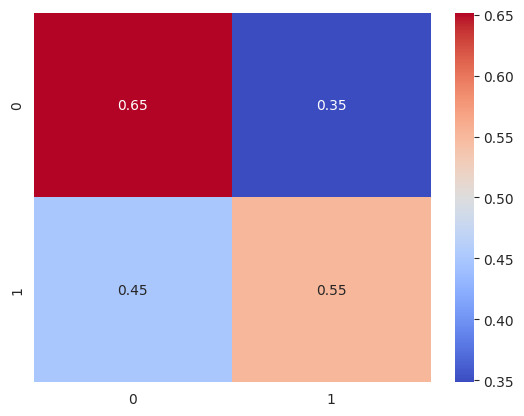

In [21]:
cm = confusion_matrix(y_test, y_test_pred, normalize='true')
sns.heatmap(cm, annot=True, fmt=".2f", cmap='coolwarm')

In [22]:
# Select the K=10 best features with highest lasso coefficients
features = pd.DataFrame({'feature': X_train.columns, 'importance': best_estimator.named_steps['randomforestclassifier'].feature_importances_})
features = features.sort_values(by='importance', ascending=False).reset_index(drop=True)
features = features.head(K)
features = features['feature'].values
features_rf = features

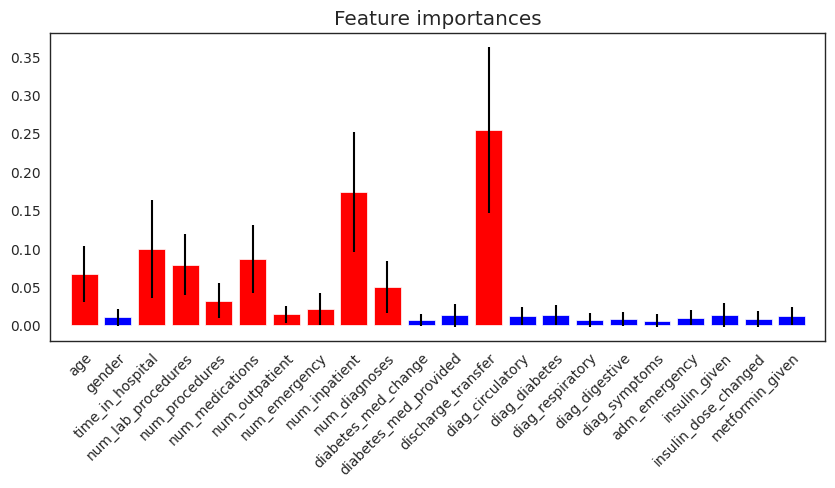

In [23]:
best_model = best_estimator.named_steps['randomforestclassifier']
importances_rf = best_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_model.estimators_],
             axis=0)

# Plot the feature importances of the forest
colors = ['r' if c in features else 'b' for c in X_train.columns]

plt.figure(1, figsize=(10, 4))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances_rf,
       color=colors, yerr=std, align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns, rotation=45, ha='right', rotation_mode='anchor')
plt.xlim([-1, X_train.shape[1]])
plt.show()

##### 3.1.1 Testing features

In [24]:
best_estimator.fit(X_train[features], y_train)

Pipeline(steps=[('randomundersampler', RandomUnderSampler(random_state=38)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=6, min_samples_leaf=10,
                                        random_state=38))])

In [25]:
y_train_pred = best_estimator.predict(X_train[features])
y_test_pred = best_estimator.predict(X_test[features])

In [26]:
ac_train = accuracy_score(y_train, y_train_pred)
ac_test = accuracy_score(y_test, y_test_pred)

print('Train accuracy: ', ac_train)
print('Test accuracy: ', ac_test)

Train accuracy:  0.6586150403580276
Test accuracy:  0.6593631998508228


In [27]:
# Visualize precision, recall, F1-score
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.94      0.67      0.78     19513
           1       0.14      0.53      0.22      1938

    accuracy                           0.66     21451
   macro avg       0.54      0.60      0.50     21451
weighted avg       0.86      0.66      0.73     21451



<Axes: >

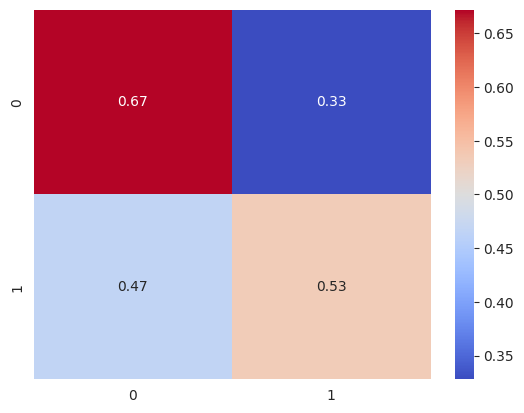

In [28]:
cm_rf = confusion_matrix(y_test, y_test_pred, normalize='true')
sns.heatmap(cm_rf, annot=True, fmt=".2f", cmap='coolwarm')

### 3.2 XGBoost

In [29]:
# Grid search parameters
params = {
    'xgbclassifier__max_depth': [6, 8, 10, 12],
    'xgbclassifier__learning_rate': [0.001, 0.01, 0.1, 0.5]
}

# Define the stratified k-fold cross-validator
kf = StratifiedKFold(n_splits=5, shuffle=False)

# Initialize the pipeline
pipeline = make_pipeline(
    RandomUnderSampler(random_state=RANDOM_STATE),
    XGBClassifier(n_estimators=100, random_state=RANDOM_STATE)
)

# Initialize the grid search
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=params,
    cv=kf,
    scoring=scoring,
    n_jobs=-1
)

# Fit the grid search
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('randomundersampler',
                                        RandomUnderSampler(random_state=38)),
                                       ('xgbclassifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_c...
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=38, ...))]),
             n_jobs=-1,
             param_grid={'xgbclassifier__learning_rate': [0.001, 0.01, 0.1,
                                                          0.5],
                         'xgbclassifier__max_depth': [6, 8, 10, 12]},
             scoring='f1_macro')

In [30]:
print('Best parameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

Best parameters: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__max_depth': 6}
Best score: 0.4938532857787923


In [31]:
# Train the best model
best_estimator = grid_search.best_estimator_
best_estimator.fit(X_train, y_train)

Pipeline(steps=[('randomundersampler', RandomUnderSampler(random_state=38)),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=38, ...))])

In [32]:
y_train_pred = best_estimator.predict(X_train)
y_test_pred = best_estimator.predict(X_test)

In [33]:
ac_train = accuracy_score(y_train, y_train_pred)
ac_test = accuracy_score(y_test, y_test_pred)

print('Train accuracy: ', ac_train)
print('Test accuracy: ', ac_test)

Train accuracy:  0.6793734516103253
Test accuracy:  0.6737215048249499


In [34]:
# Visualize precision, recall, F1-score
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.93      0.69      0.79     19513
           1       0.14      0.49      0.21      1938

    accuracy                           0.67     21451
   macro avg       0.53      0.59      0.50     21451
weighted avg       0.86      0.67      0.74     21451



<Axes: >

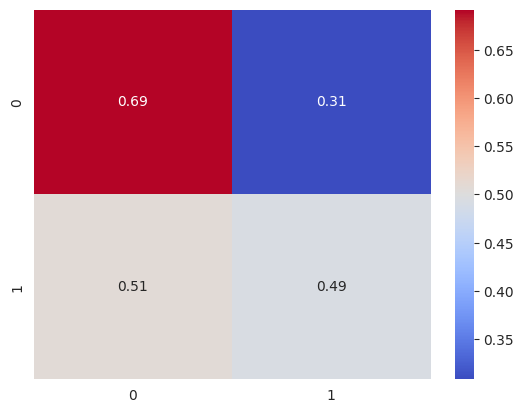

In [35]:
cm = confusion_matrix(y_test, y_test_pred, normalize='true')
sns.heatmap(cm, annot=True, fmt=".2f", cmap='coolwarm')

In [36]:
# Select the K=10 best features with highest lasso coefficients
features = pd.DataFrame({'feature': X_train.columns, 'importance': best_estimator.named_steps['xgbclassifier'].feature_importances_})
features = features.sort_values(by='importance', ascending=False).reset_index(drop=True)
features = features.head(K)
features = features['feature'].values
features_xgb = features

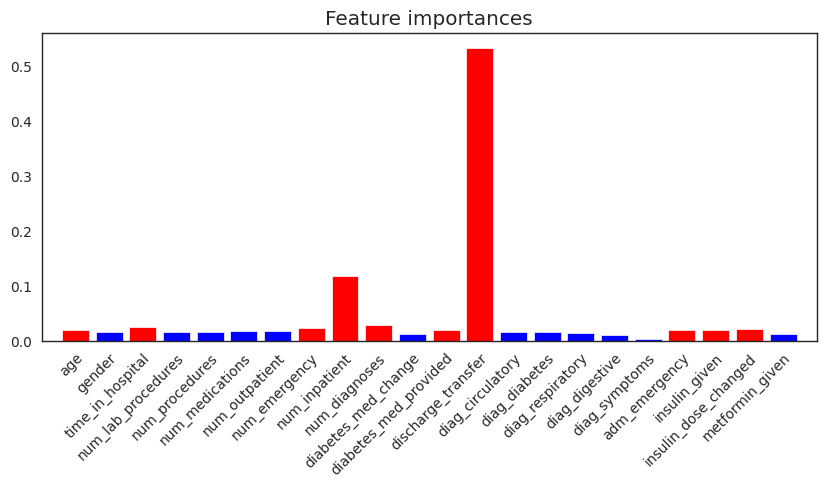

In [37]:
importances_xgb = best_estimator.named_steps['xgbclassifier'].feature_importances_
# std = np.std([tree.feature_importances_ for tree in xgb.estimators_],
#              axis=0)

# Plot the feature importances of the forest
colors = ['r' if c in features else 'b' for c in X_train.columns]

plt.figure(1, figsize=(10, 4))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances_xgb,
       color=colors, align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns,  rotation=45, ha='right', rotation_mode='anchor')
plt.xlim([-1, X_train.shape[1]])
plt.show()

##### 3.2.1 Testing features

In [38]:
best_estimator.fit(X_train[features], y_train)

Pipeline(steps=[('randomundersampler', RandomUnderSampler(random_state=38)),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=38, ...))])

In [39]:
y_train_pred = best_estimator.predict(X_train[features])
y_test_pred = best_estimator.predict(X_test[features])

In [40]:
ac_train = accuracy_score(y_train, y_train_pred)
ac_test = accuracy_score(y_test, y_test_pred)

print('Train accuracy: ', ac_train)
print('Test accuracy: ', ac_test)

Train accuracy:  0.6445896267881404
Test accuracy:  0.6435597408046245


In [41]:
# Visualize precision, recall, F1-score
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.94      0.65      0.77     19513
           1       0.14      0.55      0.22      1938

    accuracy                           0.64     21451
   macro avg       0.54      0.60      0.49     21451
weighted avg       0.86      0.64      0.72     21451



<Axes: >

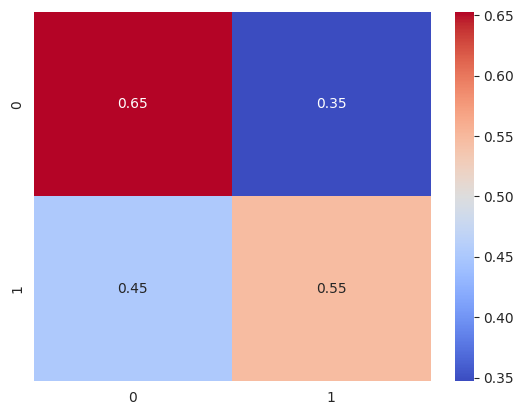

In [42]:
cm_xgb = confusion_matrix(y_test, y_test_pred, normalize='true')
sns.heatmap(cm_xgb, annot=True, fmt=".2f", cmap='coolwarm')

### 3.3 Logistic Regression

In [43]:
# Grid search parameters
params = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
}

# Define the stratified k-fold cross-validator
kf = StratifiedKFold(n_splits=5, shuffle=False)

# Initialize the pipeline
pipeline = make_pipeline(
    RandomUnderSampler(random_state=RANDOM_STATE),
    LogisticRegression(random_state=RANDOM_STATE)
)

# Initialize the grid search
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=params,
    cv=kf,
    scoring=scoring,
    n_jobs=-1
)

# Fit the grid search
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('randomundersampler',
                                        RandomUnderSampler(random_state=38)),
                                       ('logisticregression',
                                        LogisticRegression(random_state=38))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.001, 0.01, 0.1, 1, 10,
                                                   100]},
             scoring='f1_macro')

In [44]:
print('Best parameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

Best parameters: {'logisticregression__C': 10}
Best score: 0.5053237942182776


In [45]:
# Train the best model
best_estimator = grid_search.best_estimator_
best_estimator.fit(X_train, y_train)

Pipeline(steps=[('randomundersampler', RandomUnderSampler(random_state=38)),
                ('logisticregression',
                 LogisticRegression(C=10, random_state=38))])

In [46]:
y_train_pred = best_estimator.predict(X_train)
y_test_pred = best_estimator.predict(X_test)

In [47]:
ac_train = accuracy_score(y_train, y_train_pred)
ac_test = accuracy_score(y_test, y_test_pred)

print('Train accuracy: ', ac_train)
print('Test accuracy: ', ac_test)

Train accuracy:  0.6791936386158395
Test accuracy:  0.680341242832502


In [48]:
# Visualize precision, recall, F1-score
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.93      0.70      0.80     19513
           1       0.14      0.50      0.22      1938

    accuracy                           0.68     21451
   macro avg       0.54      0.60      0.51     21451
weighted avg       0.86      0.68      0.75     21451



<Axes: >

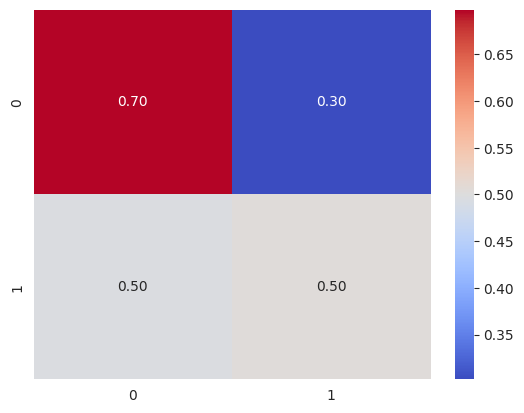

In [49]:
cm = confusion_matrix(y_test, y_test_pred, normalize='true')
sns.heatmap(cm, annot=True, fmt=".2f", cmap='coolwarm')

In [50]:
# Select the K=10 best features with highest lasso coefficients
features = pd.DataFrame({'feature': X_train.columns, 'importance': np.abs(best_estimator.named_steps['logisticregression'].coef_[0])})
features = features.sort_values(by='importance', ascending=False).reset_index(drop=True)
features = features.head(K)
features = features['feature'].values
features_lr = features

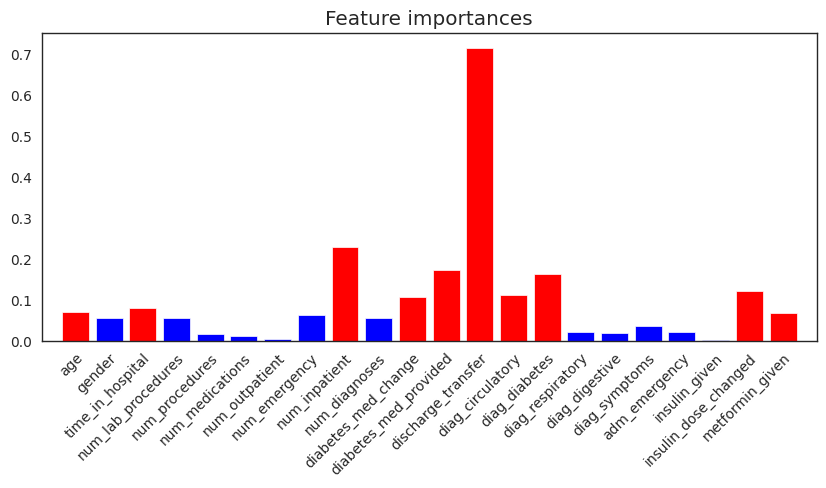

In [51]:
importances_lr = np.abs(best_estimator.named_steps['logisticregression'].coef_[0])
# std = np.std([tree.feature_importances_ for tree in xgb.estimators_],
#              axis=0)

# Plot the feature importances of the forest
colors = ['r' if c in features else 'b' for c in X_train.columns]

plt.figure(1, figsize=(10, 4))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances_lr,
       color=colors, align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns,  rotation=45, ha='right', rotation_mode='anchor')
plt.xlim([-1, X_train.shape[1]])
plt.show()

##### 3.3.1 Testing features

In [52]:
best_estimator.fit(X_train[features], y_train)

Pipeline(steps=[('randomundersampler', RandomUnderSampler(random_state=38)),
                ('logisticregression',
                 LogisticRegression(C=10, random_state=38))])

In [53]:
y_train_pred = best_estimator.predict(X_train[features])
y_test_pred = best_estimator.predict(X_test[features])

In [54]:
ac_train = accuracy_score(y_train, y_train_pred)
ac_test = accuracy_score(y_test, y_test_pred)

print('Train accuracy: ', ac_train)
print('Test accuracy: ', ac_test)

Train accuracy:  0.6886038519939263
Test accuracy:  0.6916693860426087


In [55]:
# Visualize precision, recall, F1-score
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.93      0.71      0.81     19513
           1       0.15      0.49      0.22      1938

    accuracy                           0.69     21451
   macro avg       0.54      0.60      0.52     21451
weighted avg       0.86      0.69      0.75     21451



<Axes: >

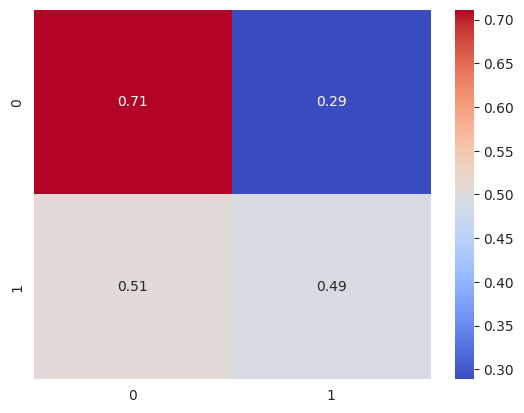

In [56]:
cm_lr = confusion_matrix(y_test, y_test_pred, normalize='true')
sns.heatmap(cm_lr, annot=True, fmt=".2f", cmap='coolwarm')

## **4. Results Combined**

### 4.1 Confusion Matrices Combined

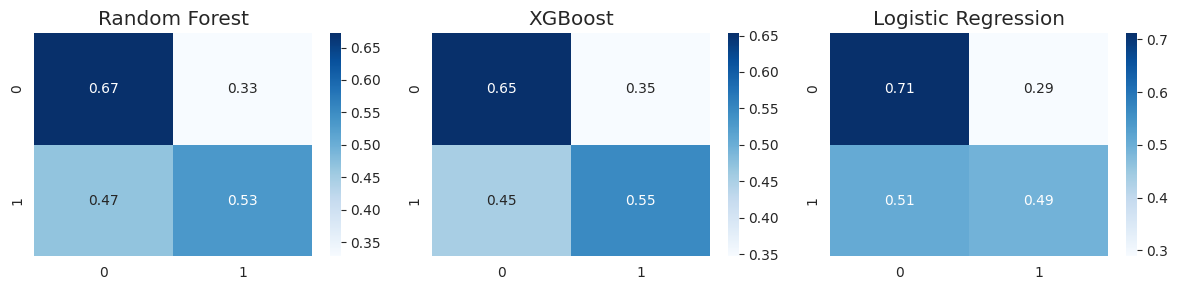

In [57]:
# Combine all confusion matrices into one single plot
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
cm_list = [cm_rf, cm_xgb, cm_lr]
titles = ['Random Forest', 'XGBoost', 'Logistic Regression']

for i, cm in enumerate(cm_list):
    sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', ax=axs[i])
    axs[i].set_title(titles[i])

plt.tight_layout()    
plt.show()

### 4.2 Feature Importances Combined

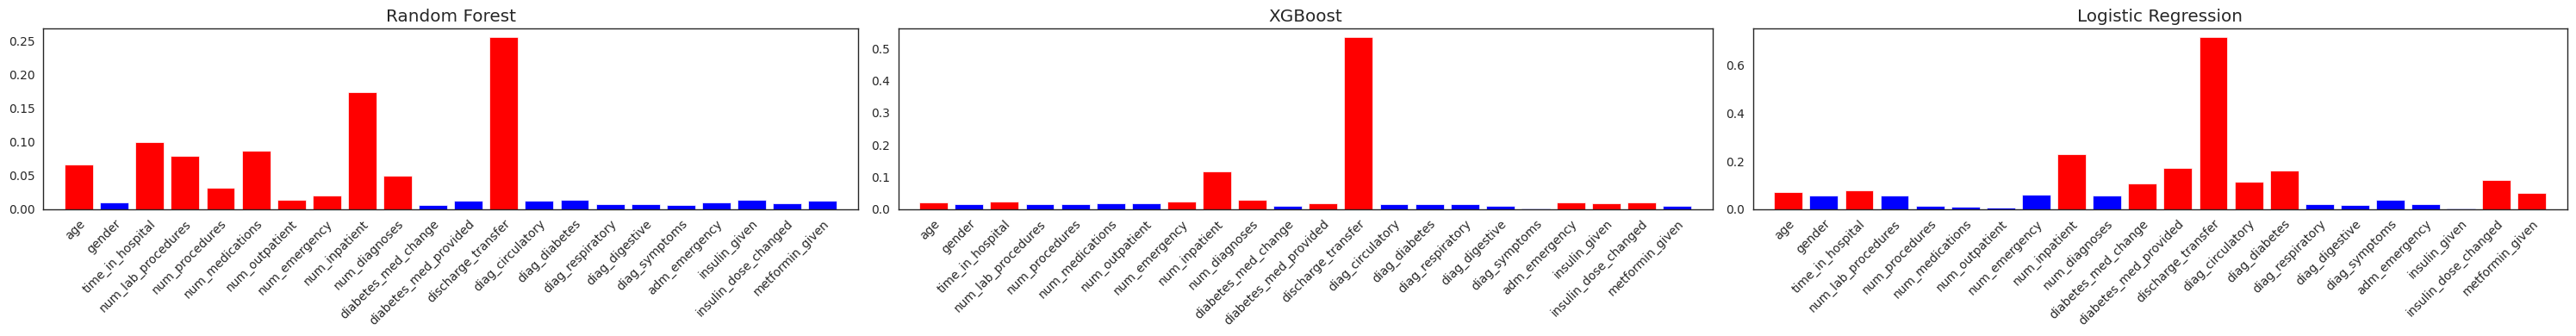

In [58]:
# Combine all feature importances plots into one single plot
fig, axs = plt.subplots(1, 3, figsize=(30, 4))
features_list = [features_rf, features_xgb, features_lr]
importances_list = [importances_rf, importances_xgb, importances_lr]
titles = ['Random Forest', 'XGBoost', 'Logistic Regression']

# Plot without labels being covered by other plots
for i, (features, importances) in enumerate(zip(features_list, importances_list)):
    colors = ['r' if c in features else 'b' for c in X_train.columns]
    axs[i%3].bar(range(X_train.shape[1]), importances,
           color=colors, align="center")
    axs[i%3].set_title(titles[i])
    axs[i%3].set_xticks(range(X_train.shape[1]))
    axs[i%3].set_xticklabels(X_train.columns, rotation=45, ha='right', rotation_mode='anchor')
    axs[i%3].set_xlim([-1, X_train.shape[1]])

plt.tight_layout()    
plt.show()

### 4.3 Selection by aggregation

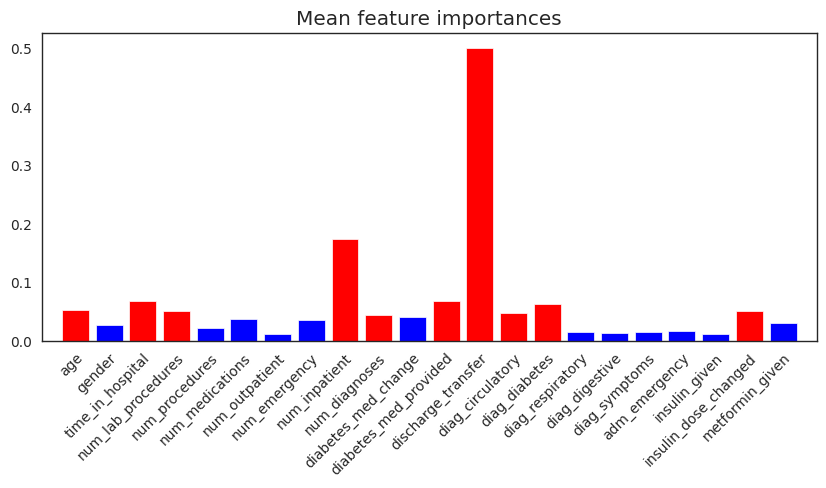

In [59]:
# Calculate the mean importances of the features
mean_importances = np.mean(importances_list, axis=0)

# Color the K features with highest mean importances in red
features = pd.DataFrame({'feature': X_train.columns, 'importance': mean_importances})
features = features.sort_values(by='importance', ascending=False).reset_index(drop=True)
features = features.head(K)
features = features['feature'].values
colors = ['r' if c in features else 'b' for c in X_train.columns]

# Plot the mean importances of the features
plt.figure(1, figsize=(10, 4))
plt.title("Mean feature importances")
plt.bar(range(X_train.shape[1]), mean_importances,
       color=colors, align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns, rotation=45, ha='right', rotation_mode='anchor')
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [60]:
selected_features = features
selected_features

array(['discharge_transfer', 'num_inpatient', 'diabetes_med_provided',
       'time_in_hospital', 'diag_diabetes', 'age', 'num_lab_procedures',
       'insulin_dose_changed', 'diag_circulatory', 'num_diagnoses'],
      dtype=object)

## **5. Final Dataset**
Filtering the dataset with the selected features, generating training and test sets, and saving them.

### 5.1 Original dataset feature filtering

In [61]:
final_diabetic_data = diabetic_data[list(selected_features) + ['readmitted']]
final_diabetic_data.reset_index(drop=True, inplace=True)
final_diabetic_data

,discharge_transfer,num_inpatient,diabetes_med_provided,time_in_hospital,diag_diabetes,age,num_lab_procedures,insulin_dose_changed,diag_circulatory,num_diagnoses,readmitted
0,0,0,1,8.0,0,5.0,77,0,1,8,1
1,0,0,0,2.0,1,5.0,49,0,0,3,0
2,1,0,1,4.0,0,8.0,68,0,0,9,0
3,0,0,1,3.0,0,8.0,46,0,1,9,0
4,0,0,1,5.0,1,3.0,49,0,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...
71498,0,0,0,1.0,0,8.0,73,0,1,9,0
71499,0,0,1,3.0,1,6.0,56,0,1,7,0
71500,0,0,1,3.0,0,8.0,39,1,1,9,0
71501,1,0,1,13.0,1,4.0,69,1,0,5,0


### 5.2 Duplicates check

In [62]:
duplicated = final_diabetic_data[diabetic_data.duplicated()]
duplicated

,discharge_transfer,num_inpatient,diabetes_med_provided,time_in_hospital,diag_diabetes,age,num_lab_procedures,insulin_dose_changed,diag_circulatory,num_diagnoses,readmitted
7649,0,0,0,5.0,0,7.0,59,0,1,8,0
37869,0,0,1,2.0,1,6.0,43,0,1,9,0
46005,0,0,1,2.0,1,7.0,57,0,1,6,0
46942,0,0,1,5.0,0,7.0,64,0,1,9,0
66065,0,0,0,4.0,0,7.0,1,0,1,9,0


In [63]:
if not duplicated.empty:
    final_diabetic_data.drop_duplicates(inplace=True)

/tmp/ipykernel_80676/2740801558.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_diabetic_data.drop_duplicates(inplace=True)


### 5.3 Training & test split

In [64]:
# Split in training and test sets
X = final_diabetic_data.drop(columns='readmitted')
y = final_diabetic_data['readmitted']

X_train, X_test, y_train, y_test = train_test_split(
    final_diabetic_data.drop(columns='readmitted'),
    y,
    test_size=0.3, # 0.3 is good
    stratify=y,
    random_state=RANDOM_STATE
)

In [65]:
# Add the 'readmitted' column back to the training and test sets
train_data = X_train.copy()
train_data['readmitted'] = y_train

test_data = X_test.copy()
test_data['readmitted'] = y_test

In [66]:
final_diabetic_data['readmitted'].value_counts()

readmitted
0    53724
1     6345
Name: count, dtype: int64

In [67]:
train_data['readmitted'].value_counts()

readmitted
0    37607
1     4441
Name: count, dtype: int64

In [68]:
test_data['readmitted'].value_counts()

readmitted
0    16117
1     1904
Name: count, dtype: int64

### 5.4 Saving to CSV

In [69]:
train_set = pd.concat([X_train, y_train], axis=1)
train_set.to_csv(DATA_PATH_PROCESSED + 'train.csv', index=False)

In [70]:
test_set = pd.concat([X_test, y_test], axis=1)
test_set.to_csv(DATA_PATH_PROCESSED + 'test.csv', index=False)